name                    L1-error (%)    L6-error (%)    max (%)    min (%)    avg (%)    std (%)
--------------------  --------------  --------------  ---------  ---------  ---------  ---------
Naive (k0=0)                6.82e-01        6.04e-11  -2.98e-05  -1.21e+00  -6.82e-01   3.59e-01
Original Quake              9.51e-02        6.31e-16  -6.47e-06  -1.75e-01  -9.51e-02   5.71e-02
Gradient descent (1)        9.28e-02        5.63e-16   0.00e+00  -1.79e-01  -9.28e-02   5.61e-02
Jan Kadlec                  4.21e-02        2.71e-18   6.50e-02  -6.50e-02   2.02e-02   4.24e-02
Gradient descent (3)        3.80e-02        1.68e-18   5.82e-02  -7.74e-02   1.35e-02   4.07e-02


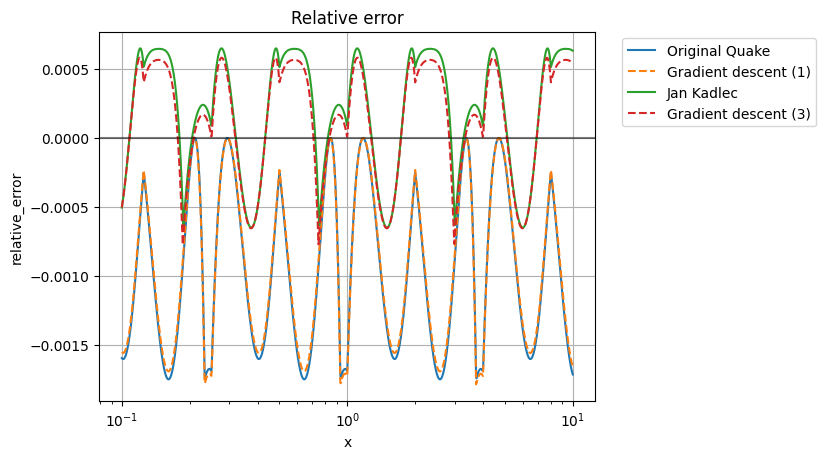

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate

def quick_invsqrt_quake(x, k0):
    Qx = np.frombuffer(x, dtype=np.int32)
    Qy = k0 - (Qx >> 1)
    y0 = np.frombuffer(Qy, dtype=np.float32)
    y1 = y0*(1.5 - 0.5*x*y0*y0)
    return y1

def quick_invsqrt_jan_kadlec(x, k):
    Qx = np.frombuffer(x, dtype=np.int32)
    Qy = k[0] - (Qx >> 1)
    y0 = np.frombuffer(Qy, dtype=np.float32)
    y1 = y0*(k[1]*x*y0*y0 + k[2])
    return y1

x = np.logspace(-1,1,1200)
y_target = 1.0/np.sqrt(x)
x = x.astype(np.float32)
y_target = y_target.astype(np.float32)

# Gradient descent coefficients were found using derive_fast_invsqrt_*.cpp
benchmarks = [
    ("Naive (k0=0)", lambda x: quick_invsqrt_quake(x, 381<<22)),
    ("Original Quake", lambda x: quick_invsqrt_quake(x, 0x5F3759DF)),
    #("Gradient descent (1)", lambda x: quick_invsqrt_quake(x, 1597311293)), # L2-norm
    ("Gradient descent (1)", lambda x: quick_invsqrt_quake(x, 1597457112)), # L6-norm
    ("Jan Kadlec", lambda x: quick_invsqrt_jan_kadlec(x, [0x5F1FFFF9, -0.703952253, 0.703952253*2.38924456])),
    #("Gradient descent (3)", lambda x: quick_invsqrt_jan_kadlec(x, [1591369693, -2.13550628, 2.43447248])), # L2-norm
    ("Gradient descent (3)", lambda x: quick_invsqrt_jan_kadlec(x, [1595889709,-0.70966386,1.68637413])), # L6-norm
]

N = len(benchmarks)
y_pred = [None]*N
y_error_rel = [None]*N
y_table = [None]*N

for i in range(N):
    (name, func) = benchmarks[i]
    y_pred[i] = func(x)
    y_error_rel[i] = (y_pred[i] - y_target) / y_target
    e = y_error_rel[i]
    e_l1 = np.mean(np.abs(e))
    e_l6 = np.mean(np.power(e,6))
    e_max = np.max(e)
    e_min = np.min(e)
    e_avg = np.mean(e)
    e_std = np.std(e)
    y_table[i] = [name, e_l1*1e2, e_l6*1e2, e_max*1e2, e_min*1e2, e_avg*1e2, e_std*1e2]
print(tabulate(y_table, headers=["name", "L1-error (%)", "L6-error (%)", "max (%)", "min (%)", "avg (%)", "std (%)"], floatfmt=".2e"))

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
for i in range(N):
    # ignore naive results, they are not worth comparing
    if i == 0: continue
    linestyle = "-" if i % 2 != 0 else "--"
    name, _ = benchmarks[i]
    ax.plot(x, y_error_rel[i], label=f"{name}", linestyle=linestyle)
ax.axhline(0, color="black", alpha=0.5)
ax.set_xscale("log")
ax.set_xlabel("x")
ax.set_ylabel("relative_error")
ax.set_title("Relative error")
ax.grid(True)
_ = ax.legend(bbox_to_anchor=(1.04, 1), loc="upper left")